## This notebook takes the output of deepcell, processes it, segments cells, and outputs the extracted channel information

In [ ]:
import os
import warnings
import numpy as np

import sys
sys.path.append('..')
sys.path.append('../ark')

from ark.utils import load_utils, segmentation_utils, io_utils, test_utils
from ark.segmentation import marker_quantification
from skimage import io

In [ ]:
# set up file paths
base_dir = "../data/example_dataset"
input_dir = os.path.join(base_dir, "input_data")
deepcell_input_dir = os.path.join(input_dir, 'deepcell_input')
tiff_dir = os.path.join(input_dir, 'single_channel_inputs')
label_dir = os.path.join(base_dir, 'deepcell_output')
viz_dir = os.path.join(base_dir, "deepcell_visualization")

In [ ]:
# create viz_dir directory if it does not already exist
if not os.path.exists(viz_dir):
    os.mkdir(viz_dir)

In [ ]:
# set to true if base images are MIBItiffs
MIBItiff = False

# points to look at (None for all)
fovs = None

In [ ]:
# validate file paths (add extra paths to this list)
io_utils.validate_paths([
    base_dir,
    input_dir,
    deepcell_input_dir,
    tiff_dir,
    label_dir,
])

### We compute the paths for the deepcell input TIFFs

In [ ]:
if fovs is None or fovs == []:
    fovs_input = io_utils.list_files(deepcell_input_dir, substrs=['tif'])
else:
    fovs_input = io_utils.list_files(deepcell_input_dir, substrs=fovs)

### We can then load the segmented mask from deepcell via label-map TIFFs and save as an xarray

In [ ]:
!rm ../data/example_dataset/deepcell_output/*.tiff

In [ ]:
segmentation_labels = load_utils.load_imgs_from_dir(data_dir=label_dir,
                                                    imgdim_name='compartments',
                                                    image_name='whole_cell',
                                                    delimiter='_feature_0',
                                                    force_ints=True)


save_name = os.path.join(label_dir, 'segmentation_labels.xr')
if os.path.exists(save_name):
    print("overwriting previously generated processed output file")
    os.remove(save_name)

segmentation_labels.to_netcdf(save_name, format="NETCDF3_64BIT")

### We can also then save the segmented mask overlaid on the imaging data

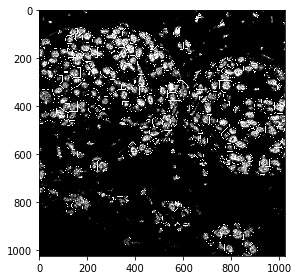

In [9]:
# Both channels and Point8

# Get input for overlay
input_data_xr = load_utils.load_imgs_from_multitiff(deepcell_input_dir,
                                                    multitiff_files=fovs_input)
# Overlaying the DNA
overlay_channels = input_data_xr.channels.values
warnings.simplefilter("ignore")

# Channel 0 and Point 8
segmentation_utils.visualize_segmentation(
            segmentation_labels_xr=segmentation_labels,
            fovs=input_data_xr[:,:,:,0].fovs.values, channel_data_xr=input_data_xr,
            chan_list = overlay_channels[0], output_dir=viz_dir)

chan_list = overlay_channels[0]

# Only displays one image because only 1 fov in dataset
for fov in input_data_xr[:,:,:,0].fovs.values:
    save_path = '_'.join([f'{fov}', *chan_list.astype('str'), 'overlay.tiff'])
    im1=io.imread(os.path.join(viz_dir, save_path))
    io.imshow(im1)

In [ ]:
# Generate random images with two fovs
rand_images = test_utils.make_images_xarray(None,
                                              fov_ids=['fov0', 'fov1', 'fov3', 'fov4'],
                                              channel_names= ['chan0', 'chan1'],
                                              row_size=1024, col_size=1024)

# Generate random labels with two fovs
rand_segmentation_labels = test_utils.make_labels_xarray(None,  fov_ids=['fov0', 'fov1', 'fov3', 'fov4'],
                                                    compartment_names = ['whole_cell'],
                                                    row_size=1024, col_size=1024)

rand_overlay_channels = rand_images.channels.values

segmentation_utils.visualize_segmentation(
            segmentation_labels_xr=rand_segmentation_labels,
            fovs=rand_images.fovs.values, channel_data_xr=rand_images,
            chan_list = rand_overlay_channels[0], output_dir=viz_dir)

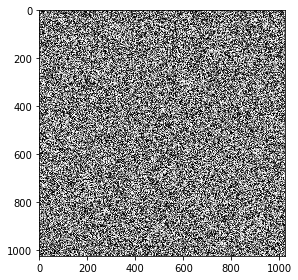

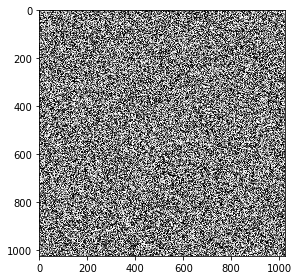

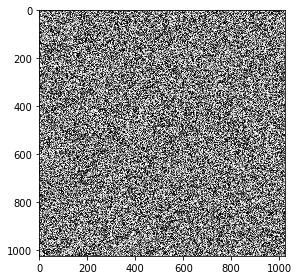

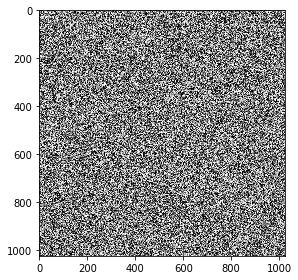

In [11]:
# This will display more images since we have multiple fovs
for fov in rand_images.fovs.values:
    chan_list = rand_overlay_channels[0]
    save_path = '_'.join([f'{fov}', *chan_list.astype('str'), 'overlay.tiff'])
    im1=io.imread(os.path.join(viz_dir, save_path))
    io.imshow(im1)
    io.show()


### Afterwards, we can generate expression matrices from the labeling + imaging data

Returns:
* cell_size_normalized_data: computed by dividing the marker counts in segmentation_labels by their corresponding cell size.
* arcsinh_transformed_data: first, linearly scale each value of cell_size_normalized_data by multiplying by 100. Then, pass the linearly scaled cell_size_normalized_data through the arcsinh function.

In [ ]:
# now extract the segmented imaging data to create normalized and transformed expression matrices
# note that if you're loading your own dataset, please make sure all the imaging data is in the same folder
# with each FOV given it's own folder and all FOVs having the same channels
combined_cell_size_normalized_data, combined_arcsinh_transformed_data = \
    marker_quantification.generate_cell_data(segmentation_labels=segmentation_labels,
                                             tiff_dir=tiff_dir,
                                             img_sub_folder="TIFs",
                                             is_mibitiff=MIBItiff,
                                             fovs=fovs,
                                             batch_size=5)

In [ ]:
# specify the path to the single_cell_output folder, and create it if it doesn't already exist
# this is where we will store our combined_normalized_data and combined_transformed_data output
single_cell_dir = os.path.join(base_dir, "single_cell_output")

if not os.path.exists(single_cell_dir):
    os.makedirs(single_cell_dir)

In [ ]:
# save output as CSV
combined_cell_size_normalized_data.to_csv(os.path.join(single_cell_dir, 'cell_size_normalized_data.csv'), index=False)
combined_arcsinh_transformed_data.to_csv(os.path.join(single_cell_dir, 'arcsinh_transformed_data.csv'), index=False)